## Random Erdos-Renyi Hypergraph Rates

In [53]:
import numpy as np
import matplotlib.pylab as plt
import random

import sys
sys.path.append('../src/')
from Hypergraphs import EmptyHypergraph
from simulate_gillespie import *
from estimate_total_rates import *

sys.path.append('../scripts/')
from generators import p1_p2_ER_like_uncorrelated_hypergraph, ER_like_random_hypergraph

## Setup

In [54]:
## --- Setup --- ##
test_name = "random_ER"
g_type = "random_ER"

N = 1000

I0 = 100

nsims = 10
run_gillespie_simulations = True

time_max = 20

beta1 = 80 / N       # pairwise infection rate
beta2 = 120 / (N**2)  # hyperedge contagion rate
mu    = 1             # recovery rate

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[3]

p1, p2 = p1_p2_ER_like_uncorrelated_hypergraph(k1,k2,N)
G, edges, triangles = ER_like_random_hypergraph(N,p1,p2)

g_edges = []
for edge in edges.tolist() + triangles.tolist():
    g_edges.append(tuple(edge))

g = EmptyHypergraph(N)
g.name = g_type
g.set_edges(g_edges)

# g.summary()

print(f"{test_name}: \n")
print(f"\tH = {g.name}, N = {N}, (k1, k2) = {(k1, k2)}, I0 = {I0}, time_max = {time_max},")
g.print()

print(f"\tbeta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu},")
print(f"\twith estimation based on {nsims} Gillespie simulation runs\n")

random_ER: 

	H = random_ER, N = 1000, (k1, k2) = (20, 6), I0 = 100, time_max = 20,
	random_ER on 1000 nodes with 12250 edges.

	beta1 * N = 80.0, beta2 * N^2 = 120.0, mu = 1,
	with estimation based on 10 Gillespie simulation runs



In [62]:
p1, p2

(0.02002002002002002, 1.2036084180372757e-05)

## Run Gillespie

exited on time=20.002890621027003, waiting_time=0.00593641634165731
exited on time=20.000693232454676, waiting_time=0.0022502955059075093
exited on time=20.000933212513974, waiting_time=0.00251358967814555
exited on time=20.000673906991672, waiting_time=0.0008048526531859501
exited on time=20.001297116396255, waiting_time=0.002065586689320775
exited on time=20.000201713050057, waiting_time=0.0011786786061405313
exited on time=20.00214171464424, waiting_time=0.0030667508315502293
exited on time=20.000172842488617, waiting_time=0.0026019895932759326
exited on time=20.00134298010255, waiting_time=0.0019871763564583904
exited on time=20.00054100330175, waiting_time=0.001675911163938684


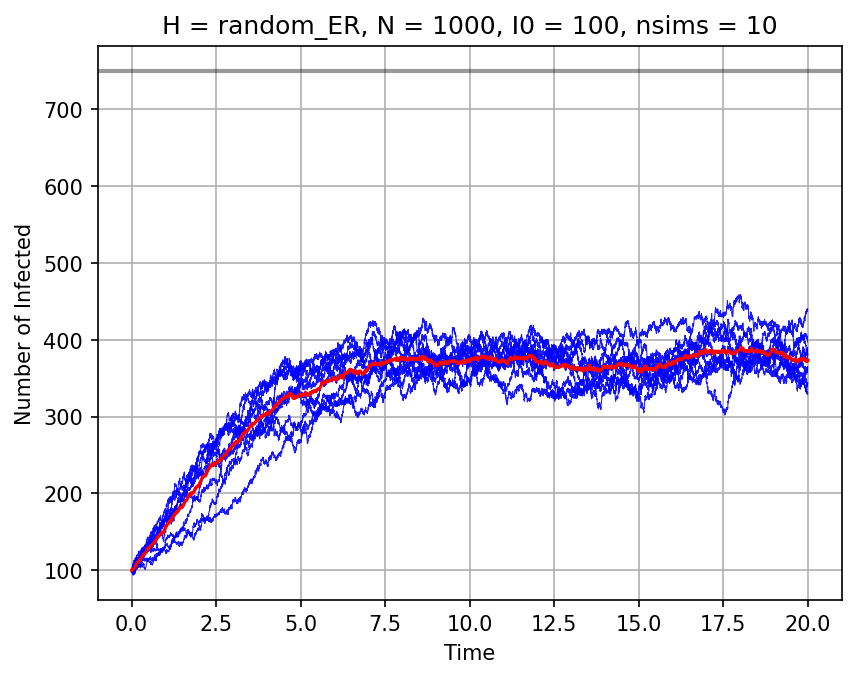

In [59]:
## --- Run Gillespie ---
# run_gillespie_simulations = False

I0_gillespie = I0 # TODO: go over the range when necessary
nodes = list(g.nodes.keys())
initial_infections = random.sample(nodes, I0)

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Calculate the estimates

In [60]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims, N, min_Tk_threshold)

Total events processed: 136620


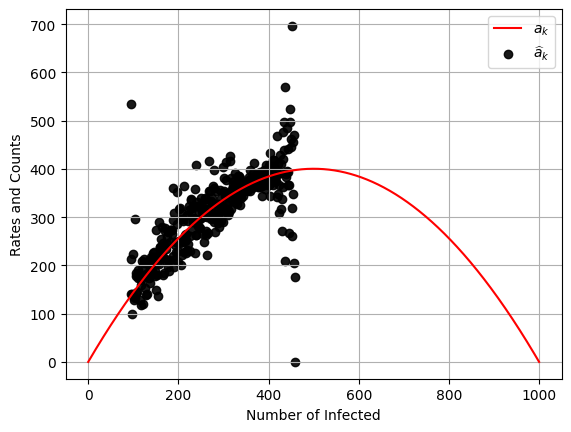

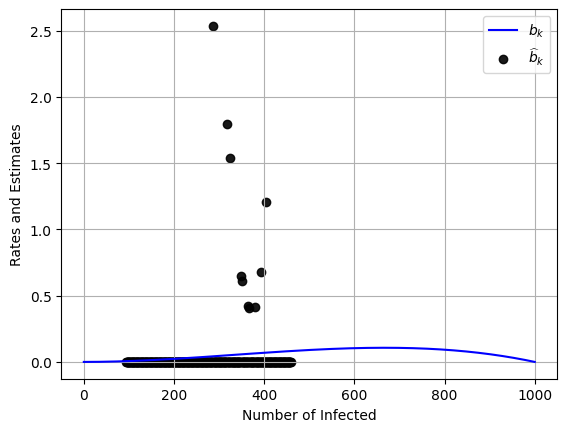

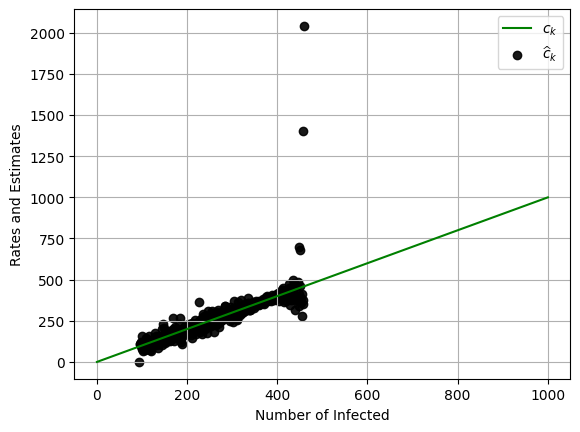

In [63]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))

# TODO: what are theoretical rates on average?
a_k = p1 * beta1 * k_values * (N - k_values)
b_k = p2 * beta2 * k_choose_2 * (N - k_values)
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_ak.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_bk.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/{test_name}/estimates_ck.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()